# 2022 CVE Data Review

This notebook will pull all [JSON Data](https://nvd.nist.gov/vuln/data-feeds#JSON_FEED) from the NVD and performs some basic data analysis of CVEd data. 

## Getting Started

### Collecting Data

This cell pulls all JSON files from the NVD that we will be working with.

In [1]:
%%capture
!rm -rf jsondata
!mkdir -p jsondata
%cd jsondata
!rm -rf *
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2002..2021}.json.zip 
!unzip -o "*.zip" 

### Import Python Libraries

In [2]:

from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import datetime
import glob
import json
import logging
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import os
import pandas as pd

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")


# CVE Data

### Build Base DataFrame

This code builds a Panda dataframe from the JSON files we downloaded, removing all CVE's marked rejected.

In [3]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                assigner = entry['cve']['CVE_data_meta']['ASSIGNER']
            except KeyError:
                published_date = 'Missing_Data_JG'
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data_JG'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data_JG'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data_JG'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data_JG'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data_JG'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data_JG'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data_JG'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data_JG'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data_JG'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data_JG'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data_JG'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data_JG'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data_JG'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner
            }
            if not description.startswith('** REJECT **'): # disputed, rejected and other non issues start with '**'
                row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
    

nvd['Published'] = pd.to_datetime(nvd['Published'])
thisyear = ((nvd['Published'] > '2021-12-01') & (nvd['Published']  < '2022-12-31'))
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
print ('CVEs from NVD in 2021:', nvd['CVE'].count())

CVEs from NVD in 2021: 20039


In [4]:
Month_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("M")).agg('count')
Year_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("Y")).agg('count')
Week_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("W")).agg('count')
Day_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("D")).agg('count')
Dayofweek_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("H")).agg('count')
Year_Graph

Published
2021    20039
Freq: A-DEC, Name: Published, dtype: int64

In [5]:
print("Published CVEs in 2021")
print("CVE-1999-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-1999-')]))
print("CVE-2000-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2000-')]))
print("CVE-2001-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2001-')]))
print("CVE-2002-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2002-')]))
print("CVE-2003-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2003-')]))
print("CVE-2004-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2004-')]))
print("CVE-2005-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2005-')]))
print("CVE-2006-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2006-')]))
print("CVE-2007-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2007-')]))
print("CVE-2008-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2008-')]))
print("CVE-2009-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2009-')]))
print("CVE-2010-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2010-')]))
print("CVE-2011-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2011-')]))
print("CVE-2012-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2012-')]))
print("CVE-2013-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2013-')]))
print("CVE-2014-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2014-')]))
print("CVE-2015-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2015-')]))
print("CVE-2016-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2016-')]))
print("CVE-2017-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2017-')]))
print("CVE-2018-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2018-')]))
print("CVE-2019-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2019-')]))
print("CVE-2020-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2020-')]))
print("CVE-2021-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2021-')]))

Published CVEs in 2021
CVE-1999-	0
CVE-2000-	0
CVE-2001-	0
CVE-2002-	2
CVE-2003-	0
CVE-2004-	0
CVE-2005-	0
CVE-2006-	0
CVE-2007-	1
CVE-2008-	2
CVE-2009-	4
CVE-2010-	11
CVE-2011-	9
CVE-2012-	4
CVE-2013-	10
CVE-2014-	1
CVE-2015-	13
CVE-2016-	14
CVE-2017-	29
CVE-2018-	76
CVE-2019-	150
CVE-2020-	3611
CVE-2021-	16102


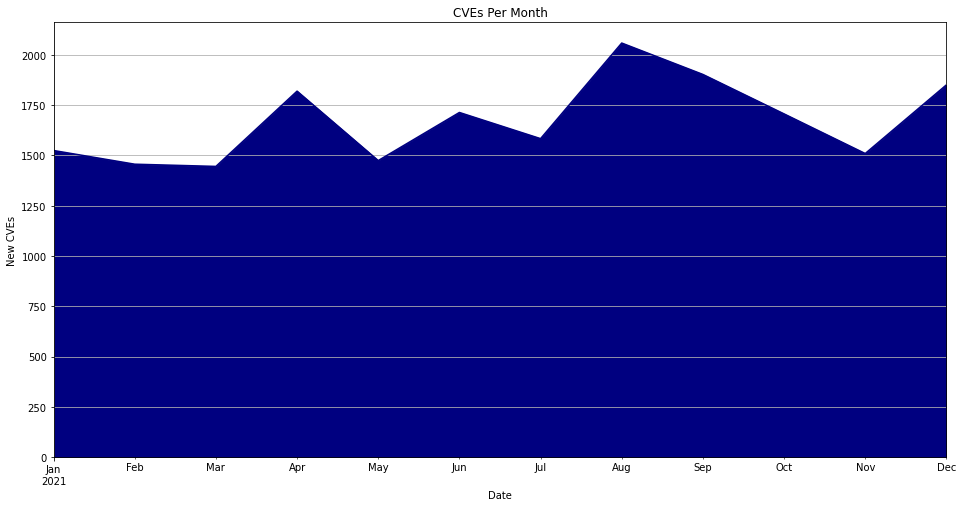

In [6]:
cg = Month_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Month')
plt.grid()
cg.set_ylabel("New CVEs")
cg.set_xlabel("Date")
plt.savefig('CVEs_Month.jpg', dpi=300, bbox_inches='tight')

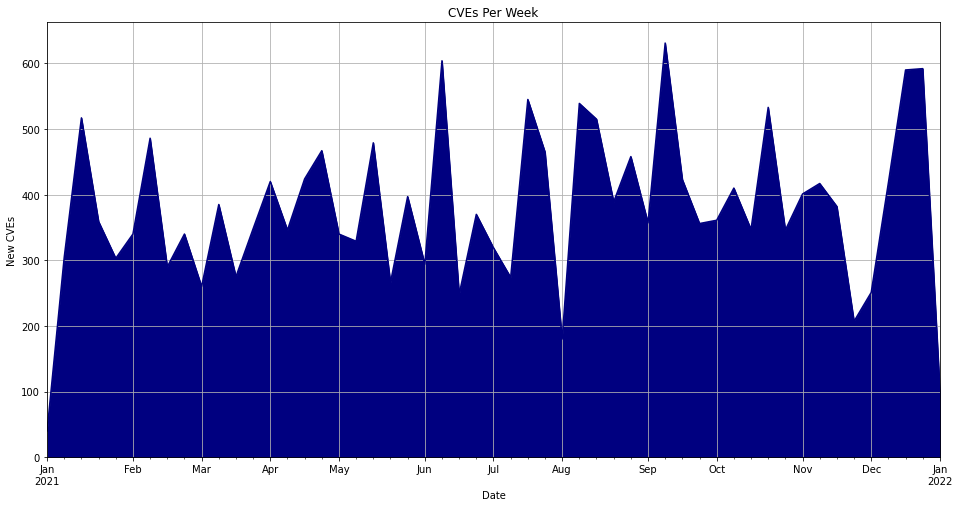

In [7]:
cg = Week_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Week')
plt.grid()
cg.set_ylabel("New CVEs")
cg.set_xlabel("Date")
plt.savefig('CVEs_Week.jpg', dpi=300, bbox_inches='tight')

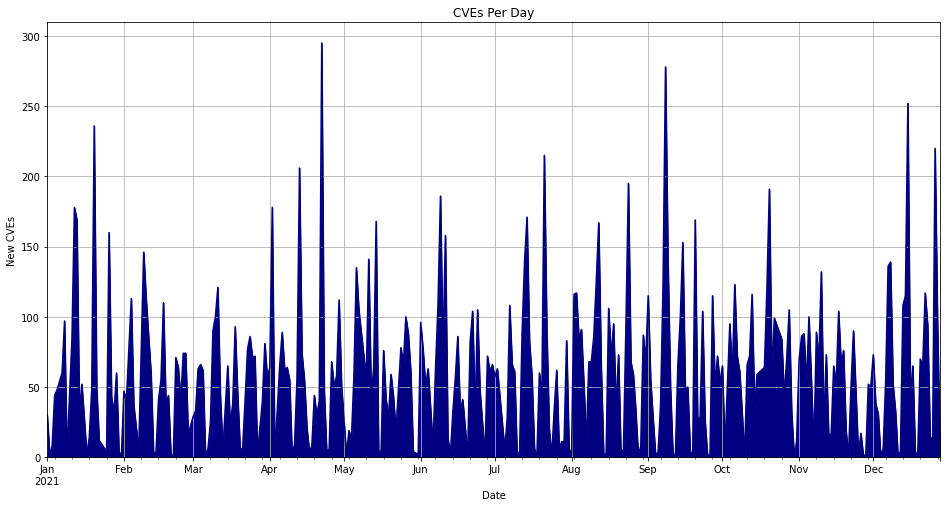

In [8]:
cg = Day_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Day')
plt.grid()
cg.set_ylabel("New CVEs")
cg.set_xlabel("Date")
plt.savefig('CVEs_Day.jpg', dpi=300, bbox_inches='tight')

In [9]:
nvd_frequency = nvd['Assigner'].value_counts()
nvd_frequency = nvd_frequency.reset_index()
nvd_frequency.columns = ['Assigner', 'counts']
nvd_frequency[nvd_frequency.counts > 100].head(50)
nvd_frequency_no_mitre = nvd_frequency[~nvd_frequency.Assigner.str.contains('cve@mitre.org')]
nvd_frequency_no_mitre = nvd_frequency_no_mitre[nvd_frequency_no_mitre.counts > 100].head(20)
nvd_frequency_no_mitre

,Assigner,counts
1,security-advisories@github.com,1065
2,secure@microsoft.com,870
3,contact@wpscan.com,747
4,psirt@us.ibm.com,604
5,secalert_us@oracle.com,586
6,psirt@cisco.com,586
7,security@android.com,530
8,secalert@redhat.com,456
9,psirt@adobe.com,431
10,product-security@apple.com,409


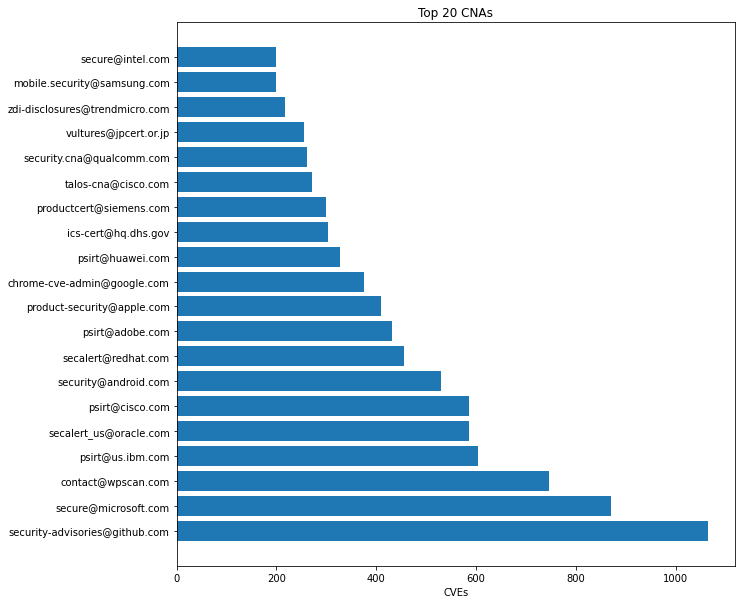

In [10]:
plt.figure(figsize=(10,10))
plt.barh("Assigner", "counts", data = nvd_frequency_no_mitre)
plt.xlabel("CVEs") 
plt.ylabel("") 
plt.title("Top 20 CNAs")
plt.savefig('2021topassinger.jpg', dpi=300, bbox_inches='tight')

In [11]:
nvd.head(5)

,CVE,Published,AttackVector,AttackComplexity,PrivilegesRequired,UserInteraction,Scope,ConfidentialityImpact,IntegrityImpact,AvailabilityImpact,BaseScore,BaseSeverity,ExploitabilityScore,ImpactScore,CWE,Description,Assigner
0,CVE-2016-20007,2021-01-01 00:15:00+00:00,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,NONE,NONE,7.5,HIGH,3.9,3.6,CWE-613,The REST/JSON project 7.x-1.x for Drupal allow...,cve@mitre.org
1,CVE-2016-20008,2021-01-01 00:15:00+00:00,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,NONE,NONE,7.5,HIGH,3.9,3.6,NVD-CWE-Other,The REST/JSON project 7.x-1.x for Drupal allow...,cve@mitre.org
2,CVE-2016-20006,2021-01-01 00:15:00+00:00,NETWORK,LOW,NONE,NONE,UNCHANGED,NONE,NONE,HIGH,7.5,HIGH,3.9,3.6,NVD-CWE-noinfo,The REST/JSON project 7.x-1.x for Drupal allow...,cve@mitre.org
3,CVE-2018-25002,2021-01-01 01:15:00+00:00,NETWORK,LOW,LOW,NONE,UNCHANGED,HIGH,HIGH,HIGH,8.8,HIGH,2.8,5.9,CWE-20,uploader.php in the KCFinder integration proje...,cve@mitre.org
4,CVE-2017-20001,2021-01-01 01:15:00+00:00,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,NONE,NONE,7.5,HIGH,3.9,3.6,CWE-326,The AES encryption project 7.x and 8.x for Dru...,cve@mitre.org
5,CVE-2016-20001,2021-01-01 01:15:00+00:00,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9,CWE-863,The REST/JSON project 7.x-1.x for Drupal allow...,cve@mitre.org
6,CVE-2019-25012,2021-01-01 01:15:00+00:00,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,NONE,NONE,7.5,HIGH,3.9,3.6,CWE-425,The Webform Report project 7.x-1.x-dev for Dru...,cve@mitre.org
7,CVE-2016-20003,2021-01-01 01:15:00+00:00,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,NONE,NONE,7.5,HIGH,3.9,3.6,NVD-CWE-Other,The REST/JSON project 7.x-1.x for Drupal allow...,cve@mitre.org
8,CVE-2016-20004,2021-01-01 01:15:00+00:00,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9,CWE-863,The REST/JSON project 7.x-1.x for Drupal allow...,cve@mitre.org
9,CVE-2016-20005,2021-01-01 01:15:00+00:00,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9,CWE-863,The REST/JSON project 7.x-1.x for Drupal allow...,cve@mitre.org


In [12]:
nvd.tail(5)

,CVE,Published,AttackVector,AttackComplexity,PrivilegesRequired,UserInteraction,Scope,ConfidentialityImpact,IntegrityImpact,AvailabilityImpact,BaseScore,BaseSeverity,ExploitabilityScore,ImpactScore,CWE,Description,Assigner
20029,CVE-2021-45905,2021-12-27 23:15:00+00:00,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,0.0,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,OpenWrt 21.02.1 allows XSS via the Traffic Rul...,cve@mitre.org
20030,CVE-2021-45906,2021-12-27 23:15:00+00:00,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,0.0,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,OpenWrt 21.02.1 allows XSS via the NAT Rules N...,cve@mitre.org
20031,CVE-2020-21237,2021-12-27 23:15:00+00:00,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,0.0,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,An issue in the user login box of LJCMS v1.11 ...,cve@mitre.org
20032,CVE-2021-45907,2021-12-28 01:15:00+00:00,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,0.0,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,An issue was discovered in gif2apng 1.9. There...,cve@mitre.org
20033,CVE-2021-45908,2021-12-28 01:15:00+00:00,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,0.0,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,An issue was discovered in gif2apng 1.9. There...,cve@mitre.org
20034,CVE-2021-45909,2021-12-28 01:15:00+00:00,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,0.0,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,An issue was discovered in gif2apng 1.9. There...,cve@mitre.org
20035,CVE-2021-45910,2021-12-28 01:15:00+00:00,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,0.0,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,An issue was discovered in gif2apng 1.9. There...,cve@mitre.org
20036,CVE-2021-45911,2021-12-28 01:15:00+00:00,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,0.0,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,An issue was discovered in gif2apng 1.9. There...,cve@mitre.org
20037,CVE-2021-20873,2021-12-28 02:15:00+00:00,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,0.0,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Yappli is an application development platform ...,vultures@jpcert.or.jp
20038,CVE-2021-4177,2021-12-28 06:15:00+00:00,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,0.0,Missing_Data_JG,Missing_Data_JG,Missing_Data_JG,CWE-209,livehelperchat is vulnerable to Generation of ...,security@huntr.dev


In [3]:
Markdown(f"This report is updated automatically every day, last generated on: **{datetime.date.today()}**")

This report is updated automatically every week, last generated on: **2021-12-29**